# Who do you want to show your marketing ad to maximum your profits?
## _Data Science Project - [Kaggle](https://www.kaggle.com/fayomi/advertising)_
### Author: Tri Minh Duong
### Email: duongtr@sheridancollege.ca

This project is divided in 4 sections:
    1. Introduction
    2. Discover Data
    3. Develop Predictive Model
    4. Actionable Recommendations

# 1. Introduction

The objective is predict who will most likely click on the ad and guide the marketing team to target the appropriate target customers. Let's consider that I am working for a marketing agency and we utilize data analysis and machine learning to execute more effective marketing campaign.

Firstly, we need to understand how profit and loss is manipulated for digital marketing advertisement. Let's assume that our marketing campaign spend __1000CAD per potential customer__. For each customer that we target with our ad campaign and that clicks on the ad, we will gain __profit of 100CAD__. If we target a customer that do not click on the ad, __a loss of 1050CAD__ will be counted. There will be a situation that the customer that we do not target for the campaign clicks on the ad. For this case, we will gain the __profit of 1100CAD__. This situation will not likely happen for start-up business as we are on the initial stage of building brand awareness.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

# 2. Discover Data

## 2.1 Loading and Exploring Dataset

In [2]:
# Loading data to data frame
advertising = pd.read_csv('advertising.csv')
advertising.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 0:53,0.0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 1:39,0.0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35,0.0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 2:31,0.0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 3:36,0.0


In [3]:
advertising.info()
print()
print(advertising.isnull().any())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 10 columns):
Daily Time Spent on Site    1018 non-null float64
Age                         1018 non-null int64
Area Income                 1018 non-null float64
Daily Internet Usage        1018 non-null float64
Ad Topic Line               1018 non-null object
City                        1018 non-null object
Male                        1018 non-null int64
Country                     1018 non-null object
Timestamp                   1018 non-null object
Clicked on Ad               1014 non-null float64
dtypes: float64(4), int64(2), object(4)
memory usage: 79.6+ KB

Daily Time Spent on Site    False
Age                         False
Area Income                 False
Daily Internet Usage        False
Ad Topic Line               False
City                        False
Male                        False
Country                     False
Timestamp                   False
Clicked on Ad                Tr

We see that our target feature 'Clicked on Ad' has some missing values. Those instances need to be removed from the dataset.

In [4]:
advertising = advertising.dropna(axis = 0)
advertising.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1014 entries, 0 to 1017
Data columns (total 10 columns):
Daily Time Spent on Site    1014 non-null float64
Age                         1014 non-null int64
Area Income                 1014 non-null float64
Daily Internet Usage        1014 non-null float64
Ad Topic Line               1014 non-null object
City                        1014 non-null object
Male                        1014 non-null int64
Country                     1014 non-null object
Timestamp                   1014 non-null object
Clicked on Ad               1014 non-null float64
dtypes: float64(4), int64(2), object(4)
memory usage: 87.1+ KB


In [5]:
# Assessing if there are duplicates in the dataset
print("Number of duplicated records in dataset: ", advertising.duplicated().sum())

Number of duplicated records in dataset:  7


In [6]:
# Removing the duplicated rows in the dataset
advertising = advertising.drop_duplicates()
advertising.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1007 entries, 0 to 1017
Data columns (total 10 columns):
Daily Time Spent on Site    1007 non-null float64
Age                         1007 non-null int64
Area Income                 1007 non-null float64
Daily Internet Usage        1007 non-null float64
Ad Topic Line               1007 non-null object
City                        1007 non-null object
Male                        1007 non-null int64
Country                     1007 non-null object
Timestamp                   1007 non-null object
Clicked on Ad               1007 non-null float64
dtypes: float64(4), int64(2), object(4)
memory usage: 86.5+ KB


In [7]:
# Looking at the distribution of target feature
click_rate = advertising["Clicked on Ad"].value_counts() / advertising.shape[0]
click_rate

1.0    0.502483
0.0    0.497517
Name: Clicked on Ad, dtype: float64

This is the quite balanced dataset on the number of potential customers who clicked and did not click on the ad. In this case, we don't need to worry about class imbalance.

In [8]:
# Extrating descriptive statistics on each numerical variable
advertising.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad
count,1007.000000,1007.000000,1007.000000,1007.000000,1007.000000,1007.000000
mean,64.952403,36.958292,54899.398868,179.386514,0.482622,0.502483
std,15.850441,31.729539,13458.555374,44.548765,0.499946,0.500242
min,32.600000,-25.000000,13996.500000,23.640000,0.000000,0.000000
25%,51.270000,29.000000,46899.780000,138.490000,0.000000,0.000000
50%,68.100000,35.000000,56984.090000,182.200000,0.000000,1.000000
75%,78.535000,42.000000,65350.775000,218.550000,1.000000,1.000000
max,91.430000,999.000000,79484.800000,269.960000,1.000000,1.000000


Our numerical variables do not seem to be skewed as the mean and the median are roughly similar. With this, it is not very neccessary to transform our data. We will confirm this assumption later by looking into each variables more deeply.

In term of spread of the data on each variable, we can see that the range of values on __Area Income__ is quite broad.

Besides, the range of __Age__ variable is quite fishy. The minimum and maximum values are not possible. We will need to investigate this more.

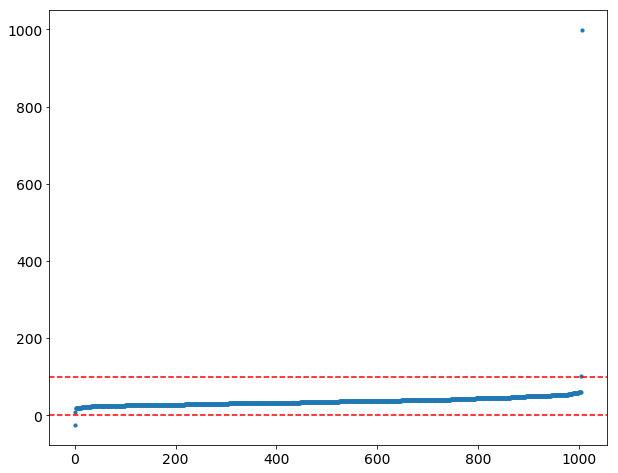

In [9]:
# Plotting sorted age against their index
sorted_age = sorted(advertising['Age'])
idx = []
for i in range(len(sorted_age)):
    idx.append(i)

x = idx
y = sorted_age

plt.rcParams["font.size"] = 14
plt.figure(figsize=(10, 8))
plt.scatter(x, y, s=10)
plt.axhline(y=0, linestyle='--', color='r')
plt.axhline(y=100, linestyle='--', color='r')
plt.savefig('age_range.png', bbox_inches='tight')

We can see that there are 3 values that are out of the normal range of age and 1 value which is seperated from other values in the normal range. They are the outliers which should be removed from the dataset. We assume that the potential customers need to be over 18 to be qualified for the advertisement. Let's how many instances that have the age under 18.

In [10]:
advertising[(advertising['Age'] < 18) | (advertising['Age'] > 100)]

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
294,56.01,-25,46339.25,127.26,Re-engineered real-time success,Garciamouth,0,Tonga,2016-07-05 18:59,1.0
495,50.60,999,34191.13,129.88,Realigned reciprocal framework,New Daniellefort,1,United States of America,2016-05-03 12:57,1.0
604,57.20,103,57739.03,110.66,Innovative maximized groupware,East Heatherside,0,New Zealand,2016-03-19 11:09,1.0
823,43.16,8,25371.52,156.11,Implemented didactic support,Williamsport,1,Marshall Islands,2016-07-06 3:40,1.0


In [11]:
# Removing the extrem Age values
advertising = advertising[(advertising['Age'] >= 18) & (advertising['Age'] < 100)]
print (advertising.shape)
advertising.head()

(1003, 10)


,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 0:53,0.0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 1:39,0.0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35,0.0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 2:31,0.0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 3:36,0.0


Let's check out if the 'Daily Time Spent on Site' is actually smaller or equal to the 'Daily Internet Usage'

In [12]:
advertising['delta'] = advertising["Daily Internet Usage"] - advertising["Daily Time Spent on Site"]
advertising[advertising['delta'] < 0]

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad,delta
114,46.13,46,37838.72,23.64,Horizontal hybrid challenge,New Rachel,1,Guyana,2016-01-09 5:44,1.0,-22.49
331,86.78,30,54952.42,70.13,Fundamental zero tolerance solution,New Steve,1,United States of America,2016-02-18 23:08,0.0,-16.65
404,66.99,47,27262.51,24.44,Operative actuating installation,Lopezberg,1,Tanzania,2016-06-15 11:56,1.0,-42.55


In [13]:
sum(advertising['delta'] < 0)

3

There are 3 instances which have 'Daily Internet Usage' less than 'Daily Time Spend on Site'. This is not reasonable so they need to be removed from dataset.

In [14]:
# Removing rows with a delta number less than 0.
advertising = advertising[advertising['delta'] >= 0]

# Dropping the column 'delta' as it is not needed for modeling
advertising = advertising.drop('delta', axis=1)

advertising.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 0:53,0.0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 1:39,0.0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35,0.0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 2:31,0.0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 3:36,0.0


## 2.2 Exploratory Data Analysis (EDA)
### 2.2.1 Descriptive Statistics for Numerical Features

In [15]:
# Functions that we will use later
import math

def creating_boxplots(size, target, features, data, save_as):
    count = len(features)
    plt.rcParams["font.size"] = 14
    plt.figure(figsize=size)
    for i in range(len(features)):
        plt.subplot(math.ceil(count/2), 2, i+1)
        sns.boxplot(x=target, y=features[i], data=data)
    if save_as[-4:] == ".png":
        plt.savefig(save_as, bbox_inches='tight')
    else:
        plt.savefig(save_as+".png", bbox_inches='tight')
                
def creating_distplots(size, features, data, save_as):
    count = len(features)
    plt.rcParams["font.size"] = 14
    plt.figure(figsize=size)
    for i in range(len(features)):
        plt.subplot(math.ceil(count/2), 2, i+1)
        sns.distplot(data[features[i]])
    if save_as[-4:] == ".png":
        plt.savefig(save_as, bbox_inches='tight')
    else:
        plt.savefig(save_as+".png", bbox_inches='tight')
        
def creating_heatmap(data, save_as):
    plt.rcParams["font.size"] = 14
    corr = data.corr()
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr,
               xticklabels=corr.columns.values,
               yticklabels=corr.columns.values)
    plt.xticks(rotation=45)
    if save_as[-4:] == ".png":
        plt.savefig(save_as, bbox_inches='tight')
    else:
        plt.savefig(save_as+".png", bbox_inches='tight')
    print(corr)

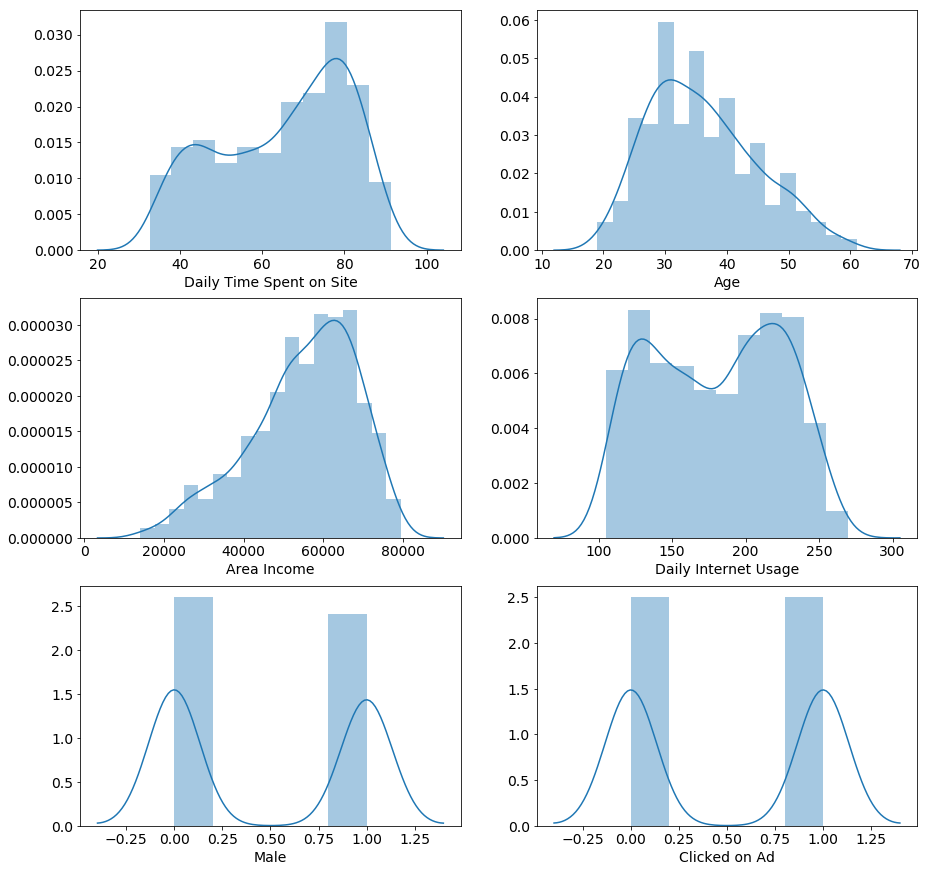

In [16]:
# Getting the name of all columns without the data type 'object' and 'datetime64' from dataframe
num_vars = advertising.select_dtypes(exclude=['object', 'datetime64']).columns

# Creating distribution plots for each numerical column
creating_distplots((15,15), num_vars, advertising, "distplot-numerical_variables.png")

The distribution plots for 'Daily Time Spent on Site' and 'Daily Internet Usage' seem to be a bimodal distributions. It means that there could be more than 1 group which is classified by these 2 features. The distribution plots for 'Age' and 'Area Income' are little skewed which could bias our predictive model later. We will use log transformation on these variables to help normalizing the data.

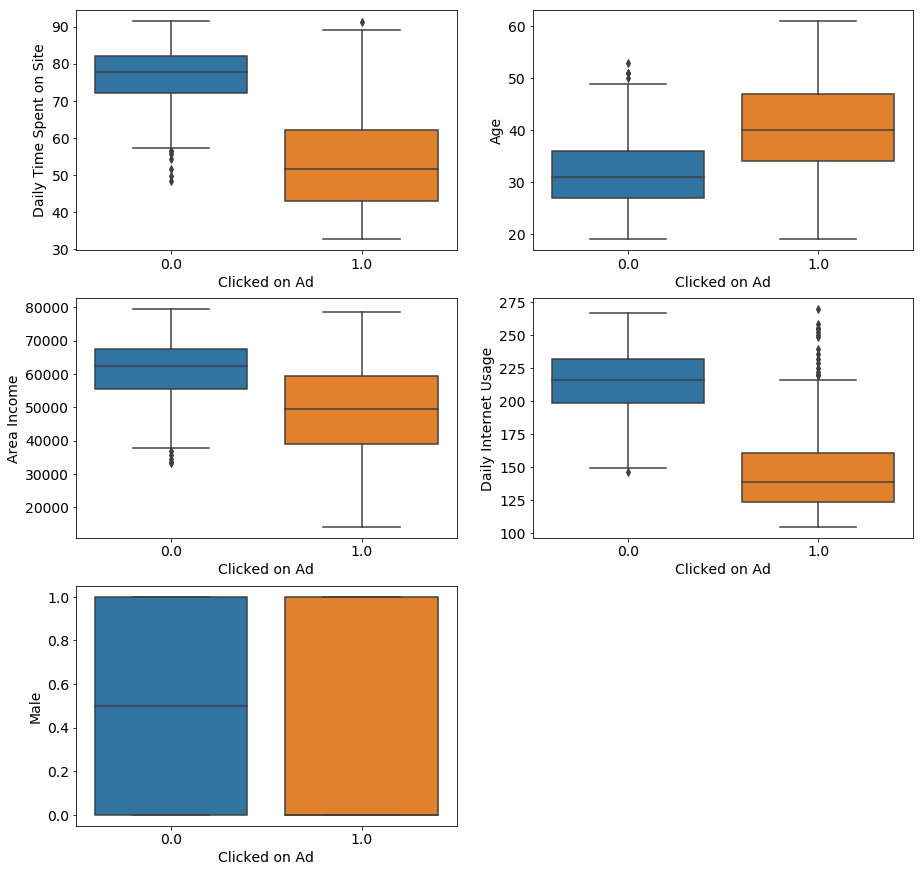

In [17]:
# Creating box plots for each numerical column
target = "Clicked on Ad"
num_vars1 = num_vars.drop(labels="Clicked on Ad")
creating_boxplots((15,15), target, num_vars1, advertising, "boxplot-numerical_variables.png")

The boxplots on 'Daily Tim Spent on Site' and 'Daily Internet Usage' show a significant difference between 2 groups, people who clicked on the Ad and people who did not. Furthermore, we will observe a potential trend between these 2 groups with 'Age' and 'Area Income' respectively.

                          Daily Time Spent on Site       Age  Area Income  \
Daily Time Spent on Site                  1.000000 -0.331513     0.310954   
Age                                      -0.331513  1.000000    -0.182605   
Area Income                               0.310954 -0.182605     1.000000   
Daily Internet Usage                      0.518658 -0.367209     0.337496   
Male                                     -0.018951 -0.021044     0.001322   
Clicked on Ad                            -0.748117  0.492531    -0.476255   

                          Daily Internet Usage      Male  Clicked on Ad  
Daily Time Spent on Site              0.518658 -0.018951      -0.748117  
Age                                  -0.367209 -0.021044       0.492531  
Area Income                           0.337496  0.001322      -0.476255  
Daily Internet Usage                  1.000000  0.028012      -0.786539  
Male                                  0.028012  1.000000      -0.038027  
Clicked on Ad   

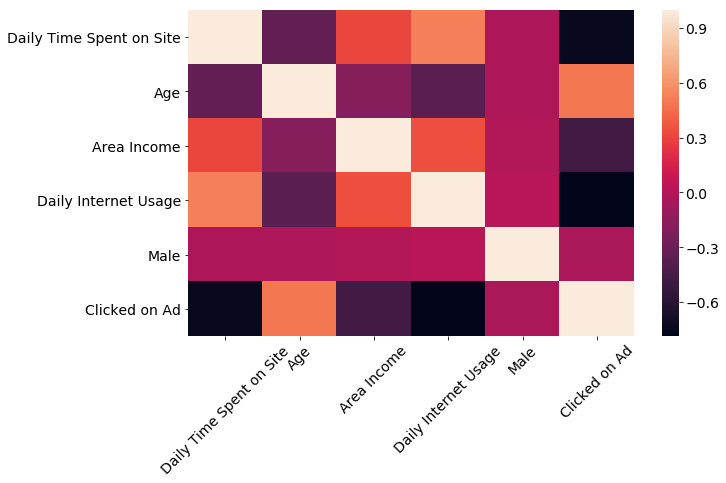

In [18]:
# Manipulating the correlation between the numerical features in dataset and visualizing them in heat map
creating_heatmap(advertising, "correlation-numerical_variables.png")

The cross-correlation above revealed potential relationship between our target feature 'Clicked on Ad' with other features except gender. Now we would need to keep these relationship in mind since there could be some collinearity between the explanatory features.

### 2.2.2 Distribution Plots with Respect to Our Target Feature

In [19]:
# Building function to create plots between features and target
def creating_plots(size, features, data, save_as):
    click_yes = data["Clicked on Ad"] == 1
    click_no = data["Clicked on Ad"] == 0
    labels = ["Click", "No Click"]
    
    plt.rcParams["font.size"] = 14
    plt.figure(figsize=size)
    
    count = len(features)
    for feature in features:
        plt.subplot(math.ceil(count/2), 2, features.index(feature)+1)
        sns.distplot(data[feature][click_yes], label=labels[0], color="b")
        sns.distplot(data[feature][click_no], label=labels[1], color="y")
        plt.axvline(data[feature][click_yes].mean(), linestyle="--", color="b")
        plt.axvline(data[feature][click_no].mean(), linestyle="--", color="y")
        plt.legend()
        
    if save_as[-4:] == ".png":
        plt.savefig(save_as, bbox_inches='tight')
    else:
        plt.savefig(save_as+".png", bbox_inches='tight')

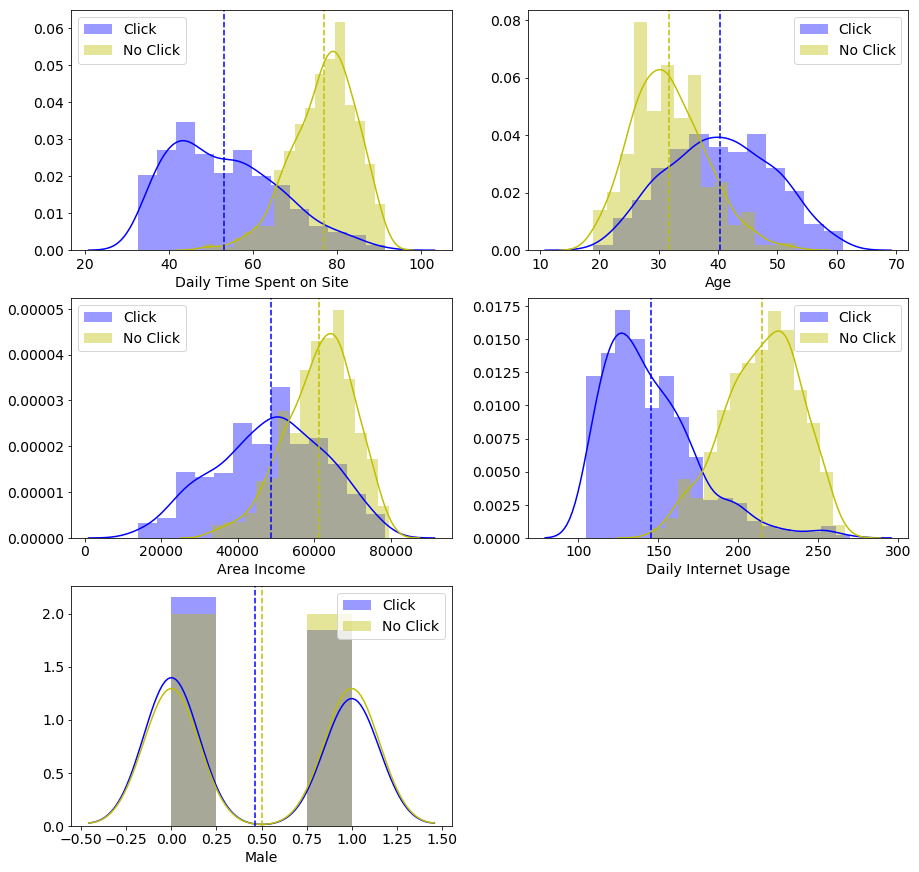

In [20]:
# Creating plots
features = ["Daily Time Spent on Site", "Age", "Area Income", "Daily Internet Usage", "Male"]

creating_plots((15, 15), features, advertising, "distplot-numerical_variables-target.png")

We observe the significant differences on 'Daily Time Spent on Site' and 'Daily Internet Usage' between the people who clicked the ad and who did not. The people who clicked ad tended to have less time spent on site and less daily internet usage.
In term of Age, the distribution of people who clicked on ad spreaded out from around 20 to 60 years old, while the distribution of people who did not clicked on ad are in the range between 20 and less than 50 years old.

C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


<Figure size 432x288 with 0 Axes>

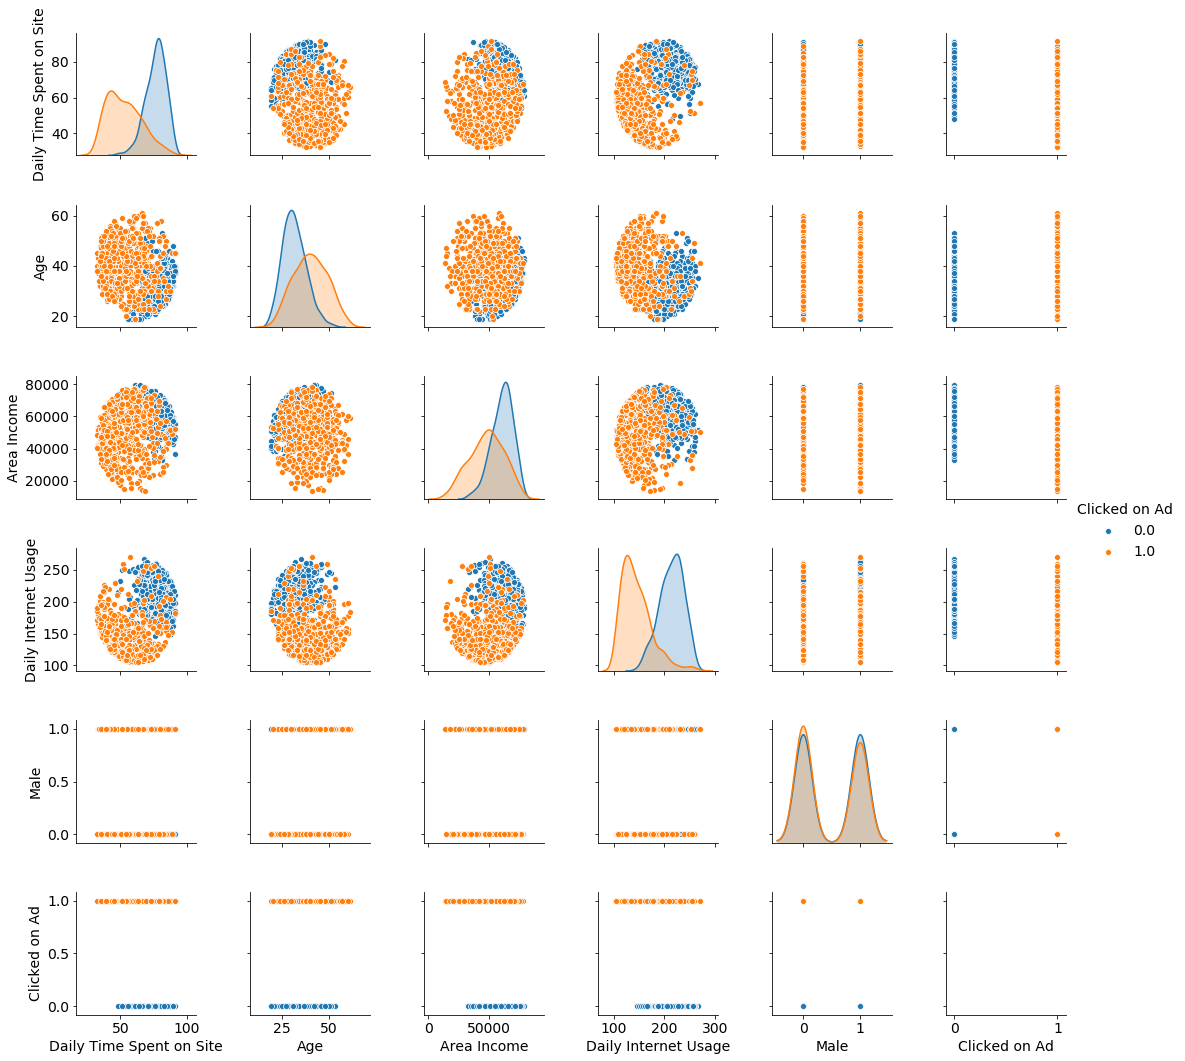

In [21]:
# create pair plots with respect to our target feature
plt.rcParams["font.size"] = 14
plt.figure()
sns.pairplot(data=advertising[num_vars],
            hue="Clicked on Ad",
            dropna=True)
plt.savefig("pairplot-numerical_variables-target.png", bbox_inches='tight')

We can see that the 2 groups of users, people who clicked on the ad and people who did not, were classified quite clearly with regard of 'Daily Internet Usage' and 'Daily Time Spent on Site'.

### 2.2.3 Distribution of Categorical Features

In [22]:
# Counting number of unique values of City
print("Count of unique values of City feature: ", advertising["City"].nunique())

print("Count of number of values of City feature: ", advertising["City"].count())

Count of unique values of City feature:  969
Count of number of values of City feature:  1000


There are 969 different cities in the dataset out of 1000 instances. It means that there are almost no chance to have many instances from the same city. Therefore, we can guess that this feature has no predictive power.

However, we have less diversity when it comes down to different countries, so we will take a look at the distribution of our dataset with regard to the feature "Country".

In [23]:
print("Count of unique values of feature Country: ", advertising["Country"].nunique())

country_count = pd.crosstab(index=advertising["Country"], columns="count")
country_count.describe()

Count of unique values of feature Country:  237


col_0,count
count,237.000000
mean,4.219409
std,1.837222
min,1.000000
25%,3.000000
50%,4.000000
75%,6.000000
max,9.000000


In [24]:
clicked_country_count = pd.crosstab(advertising["Country"],
                                    advertising["Clicked on Ad"],
                                    rownames=['Country'],
                                    colnames=["Clicked on Ad"])
clicked_country_count.sort_values(1, 0, ascending=False).head(10)

Clicked on Ad,0.0,1.0
Country,,
Australia,1,7
Turkey,1,7
Ethiopia,0,7
Liberia,2,6
South Africa,2,6
Liechtenstein,0,6
Senegal,3,5
Peru,3,5
Mayotte,1,5


The users in this dataset are fairly spread out across the world with a total of 237 countries. The maximum number of users which were from the same country is 9. This made the feature have very little power to predict whether a user would click on the ad.

# 3. Develop Predictive Model
## 3.3 Prepare Data and Feature Engineering

Before developing a machine learning model, we need to split the dataset into training and testing datasets.

In [25]:
# select a firm random_state to ensure all methods run in the same random_state
random_state = 42

# Split the dataset to training and testing sets
target = "Clicked on Ad"

X, y = advertising.drop([target], axis = 1), advertising[target]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   random_state = random_state)

# Review training and testing sets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(800, 9)
(800,)
(200, 9)
(200,)


### 3.3.1 Removing Some Features

For the scope of this model, we will remove some features that would need a special approach like Natural Language Processing, and time-related analysis to keep our model simple. Furthermore, we will not be considering the "City" feature because it does not have predictive power as mentioned earlier.

In [26]:
X_train = X_train.drop(["Ad Topic Line", "City", "Timestamp"], axis=1)
X_train.head(5)

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Country
29,76.02,22,46179.97,209.82,0,Bouvet Island (Bouvetoya)
546,73.57,30,70377.23,212.38,0,Uruguay
707,68.25,33,76480.16,198.86,1,Vanuatu
568,56.20,49,53549.94,114.85,1,Bahamas
850,63.11,34,63107.88,254.94,1,Micronesia


In [27]:
X_test = X_test.drop(["Ad Topic Line", "City", "Timestamp"], axis=1)
X_test.head(5)

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Country
532,46.61,42,65856.74,136.18,0,Ethiopia
750,79.80,28,57179.91,229.88,1,Bahamas
753,82.37,30,63664.32,207.44,0,Tonga
672,76.42,26,60315.19,223.16,1,Netherlands Antilles
420,48.09,33,19345.36,180.42,0,Heard Island and McDonald Islands


### 3.3.2 Normalization of Numerical Features

In [28]:
# Defining categorical and numerical variables that we will use later
categorical_vars = ["Country"]
numerical_vars = ["Daily Time Spent on Site", "Age", "Area Income", "Daily Internet Usage", "Male"]

# Initializing Min Max Scaler
scaler = MinMaxScaler()

# Applying the scaler to transform all numerical variables
X_train[numerical_vars] = scaler.fit_transform(X_train[numerical_vars])
X_test[numerical_vars] = scaler.transform(X_test[numerical_vars])

C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [29]:
X_train.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Country
29,0.738812,0.071429,0.491438,0.635427,0.0,Bouvet Island (Bouvetoya)
546,0.697124,0.261905,0.860928,0.650946,0.0,Uruguay
707,0.606602,0.333333,0.954119,0.568986,1.0,Vanuatu
568,0.401565,0.714286,0.603977,0.059711,1.0,Bahamas
850,0.519142,0.357143,0.749926,0.908948,1.0,Micronesia


In [30]:
X_test.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Country
532,0.238387,0.547619,0.791901,0.189016,0.0,Ethiopia
750,0.803131,0.214286,0.659406,0.757032,1.0,Bahamas
753,0.846861,0.261905,0.758423,0.620999,0.0,Tonga
672,0.745619,0.166667,0.707282,0.716295,1.0,Netherlands Antilles
420,0.263570,0.333333,0.081677,0.457202,0.0,Heard Island and McDonald Islands


### 3.3.3 Processing Categorical Feature
We will use LabelEncoder to convert the string values in categorical variable 'Country' to numeric values. The object LabelEncoder will fit the Country values in train set and transform in both train and test sets. By doing so, there could be some instances in test set that have the country names which were not in train set. To avoid the model to be scrash when running in production, there will be a value called 'Others' with which those country names will be replaced.

In [31]:
# Get list of unique countries which exist in train set
X_train_original = X_train
countries = X_train['Country'].unique()
# Add another value 'Others' to the list
countries = np.append(countries, 'Others')
countries
# Fit the list 'countries' with numeric labels
le = LabelEncoder()
le.fit(countries)
# Replace current values in column 'Country' in train set with matches numeric values
X_train['Country'] = le.transform(X_train['Country'])

le.classes_

array(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Angola',
       'Anguilla', 'Antarctica (the territory South of 60 deg S)',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina',
       'Bouvet Island (Bouvetoya)', 'Brazil',
       'British Indian Ocean Territory (Chagos Archipelago)',
       'British Virgin Islands', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada',
       'Cayman Islands', 'Chad', 'Chile', 'China', 'Christmas Island',
       'Colombia', 'Comoros', 'Congo', 'Cook Islands', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
 

In [32]:
X_train.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Country
29,0.738812,0.071429,0.491438,0.635427,0.0,26
546,0.697124,0.261905,0.860928,0.650946,0.0,223
707,0.606602,0.333333,0.954119,0.568986,1.0,225
568,0.401565,0.714286,0.603977,0.059711,1.0,14
850,0.519142,0.357143,0.749926,0.908948,1.0,133


In [33]:
X_test_original = X_test
# Replace the country name in test set which is not in list 'Countries' with categorical value 'Others'
X_test['Country'] = X_test['Country'].map(lambda s: 'Others' if s not in le.classes_ else s)
X_test[X_test['Country'] == 'Others']

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Country
633,0.836311,0.119048,0.590329,0.515761,1.0,Others
674,0.232772,0.166667,0.550615,0.750364,1.0,Others
880,0.117917,0.333333,0.400794,0.225570,1.0,Others
647,0.448358,0.857143,0.645095,0.159372,1.0,Others
837,0.690999,0.261905,0.565244,0.894762,1.0,Others
86,0.764165,0.404762,0.910144,0.579231,0.0,Others
907,0.087460,0.500000,0.790630,0.521035,0.0,Others
655,0.739663,0.404762,0.825140,0.791465,0.0,Others
815,0.352731,0.357143,0.462352,0.040192,1.0,Others


In [34]:
# Replace current values in column 'Country' in test set with matches numeric values
X_test['Country'] = le.transform(X_test['Country'])
X_test.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Country
532,0.238387,0.547619,0.791901,0.189016,0.0,61
750,0.803131,0.214286,0.659406,0.757032,1.0,14
753,0.846861,0.261905,0.758423,0.620999,0.0,209
672,0.745619,0.166667,0.707282,0.716295,1.0,146
420,0.263570,0.333333,0.081677,0.457202,0.0,87


## 3.2 Model Selection

We will develop the predictive model using either **Logistic Regression** or **Random Forest Classifier**. There are 4 possible outcomes on the evaluation results for each prediction:
- True Positive
- False Positive
- False Negative
- True Negative

As mentioned at the beginning, for each customer that we target for our ad campaign and that clicks on the ad, we will gain profit of 100CAD. If we target a customer that do not click on the ad, there will be a lost of 1050CAD. For each customer that we don't target for our campaign but end up clicking on the ad, the company will gain a profit of 1100CAD. 

Therefore, we will need to lower the number of customers who we target but do not click on the ad. With that, we will need to lower the false positive. Hence, we will use precision score as our evaluation score for model selection. The higher precision score the model has, the better the model is.

### 3.2.1 Logistic Regression

In [35]:
# To search the best parameters for the algorithm based on evaluation score
def search_parameters(model, parameters, num_folds, precisions):
    gs = GridSearchCV(model, param_grid=parameters, scoring='precision', n_jobs=-1, cv=num_folds)
    # Fit the Grid Search object to the training dataset
    gs.fit(X_train, y_train)
    precisions[gs.best_estimator_] = gs.best_score_
    
    # Performance metrics
    print("\nOptimized Model:\n---------")
    print("Evaluation score function:", gs.scorer_, "=", gs.best_score_)
    print(gs.best_estimator_)

In [36]:
# identify basic inputs:
num_folds = 4
precisions = {}

# run GridSearchCV to tune hyparameters for Logistic Regression
model = LogisticRegression(random_state=random_state)
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
search_parameters(model, parameters, num_folds, precisions)


Optimized Model:
---------
Evaluation score function: make_scorer(precision_score) = 0.9870660551454624
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The previous step highlighted a value of 1 for C parameter used in the L2-Regularization which will give us the best model. We will now perform another search with a much narrower search in order to identify the best parameter.

In [37]:
parameters = {"C": [0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]}
search_parameters(model, parameters, num_folds, precisions)


Optimized Model:
---------
Evaluation score function: make_scorer(precision_score) = 0.9871220461868958
LogisticRegression(C=1.2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The second round of searching best model gives us a value of 1.2 for C parameter. The evaluation score given by this best Logistic Regression model is 98.7122%.

Now we are looking into what the best model that Random Forest Classifier can give us.

### 3.2.2 Random Forest Classifier

We will tune each parameter by hand to explore the changes in out-of-bag score and precision score as well as estimate the possible range of values we could use for tuning the model with multiple parameters at the same time.

In [38]:
model_rf = RandomForestClassifier(oob_score=True, random_state=42)
model_rf.fit(X_train, y_train)

# get predictions based on recent model and train set
y_train_pred = model_rf.predict(X_train)

# get Fbeta_score based on predictions on train set
print("Precision score:", round(precision_score(y_train, y_train_pred), 2))
print("OOB score:", round(model_rf.oob_score_, 2))

Precision score: 1.0
OOB score: 0.94


C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


#### Tuning Parameters: Max Depth

C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Depth = 5
Precision score: 0.9923076923076923
OOB score: 0.95




C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Depth = 6
Precision score: 0.9949367088607595
OOB score: 0.94125




C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Depth = 7
Precision score: 0.9974619289340102
OOB score: 0.945




C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Depth = 8
Precision score: 1.0
OOB score: 0.94125




C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Depth = 9
Precision score: 0.9974811083123426
OOB score: 0.9425




C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Depth = 10
Precision score: 0.9974874371859297
OOB score: 0.9425




C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Depth = 11
Precision score: 0.9974874371859297
OOB score: 0.9425




C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Depth = 12
Precision score: 0.9974874371859297
OOB score: 0.9425




C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Depth = 13
Precision score: 0.9974874371859297
OOB score: 0.9425




C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Depth = 14
Precision score: 0.9974874371859297
OOB score: 0.9425




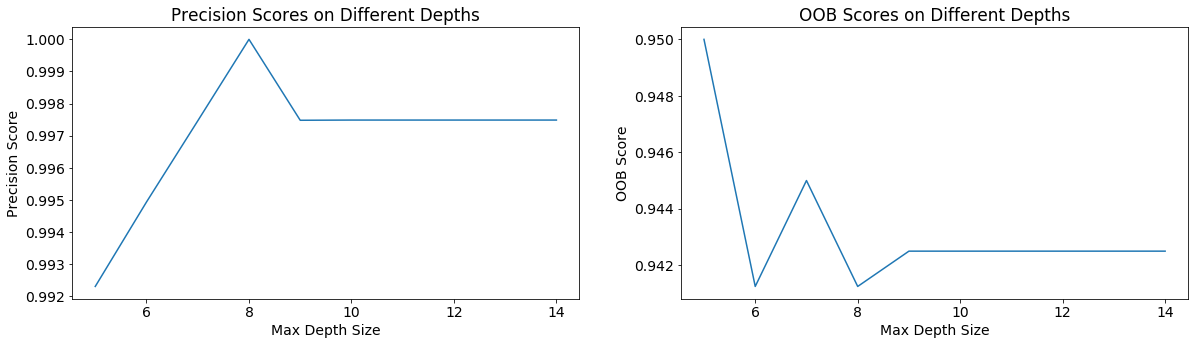

In [39]:
oob_scores = []
precision_scores = []
max_depth_sizes = np.arange(5, 15, 1)

for depth in max_depth_sizes:
    model_rf = RandomForestClassifier(max_depth=depth, oob_score=True, n_jobs=-1, random_state=42)
    model_rf.fit(X_train, y_train)
    print("Depth =", depth)
    y_train_pred = model_rf.predict(X_train)
    precision_train = precision_score(y_train, y_train_pred)
    oob_score = model_rf.oob_score_
    print('Precision score:', precision_train)
    print('OOB score:', oob_score)
    oob_scores.append(oob_score)
    precision_scores.append(precision_train)
    print("\n")

plt.rcParams["font.size"] = 14
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(max_depth_sizes, precision_scores)
plt.xlabel('Max Depth Size')
plt.ylabel('Precision Score')
plt.title('Precision Scores on Different Depths')

plt.subplot(1, 2, 2)
plt.plot(max_depth_sizes, oob_scores)
plt.xlabel('Max Depth Size')
plt.ylabel('OOB Score')
plt.title('OOB Scores on Different Depths')
plt.show()

#### Tuning Parameters: n_estimators

C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Number of trees: 1
Precision score: 0.9725
OOB score: 0.66


Number of trees: 2
Precision score: 0.9947780678851175
OOB score: 0.76


Number of trees: 3


C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Precision score: 0.992462311557789
OOB score: 0.825


Number of trees: 4


C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Precision score: 0.9949494949494949
OOB score: 0.8625


Number of trees: 5


C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Precision score: 0.9900249376558603
OOB score: 0.88375


Number of trees: 15


C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Precision score: 1.0
OOB score: 0.95375


Number of trees: 20
Precision score: 1.0
OOB score: 0.9525


Number of trees: 25
Precision score: 1.0
OOB score: 0.95125


Number of trees: 30
Precision score: 1.0
OOB score: 0.9525


Number of trees: 35
Precision score: 1.0
OOB score: 0.955


Number of trees: 40
Precision score: 1.0
OOB score: 0.955


Number of trees: 50
Precision score: 1.0
OOB score: 0.95875


Number of trees: 60
Precision score: 1.0
OOB score: 0.9575


Number of trees: 70
Precision score: 1.0
OOB score: 0.95875


Number of trees: 100
Precision score: 1.0
OOB score: 0.96




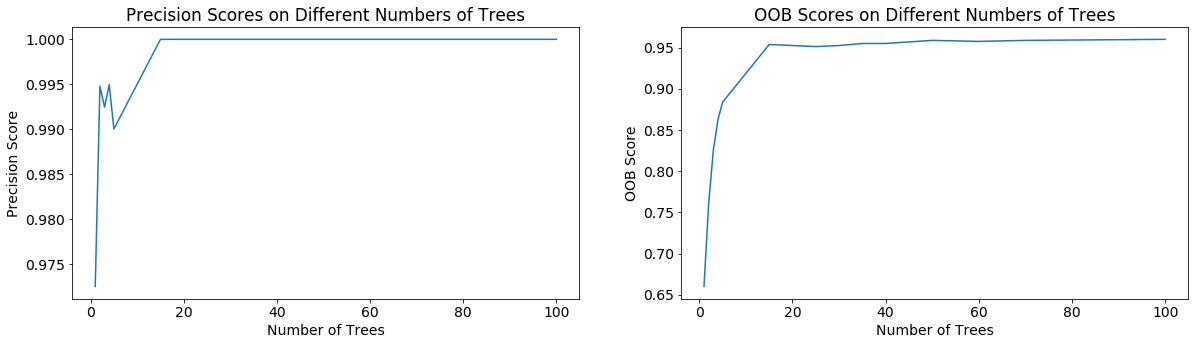

In [40]:
oob_scores = []
precision_scores = []
n_estimator_options = [1, 2, 3, 4, 5, 15, 20, 25, 30, 35, 40, 50, 60, 70, 100]

for trees in n_estimator_options:
    model_rf = RandomForestClassifier(n_estimators=trees, oob_score=True, n_jobs=-1, random_state=42)
    model_rf.fit(X_train, y_train)
    print("Number of trees:", trees)
    y_train_pred = model_rf.predict(X_train)
    precision_train = precision_score(y_train, y_train_pred)
    oob_score = model_rf.oob_score_
    print('Precision score:', precision_train)
    print('OOB score:', oob_score)
    oob_scores.append(oob_score)
    precision_scores.append(precision_train)
    print("\n")

plt.rcParams["font.size"] = 14
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(n_estimator_options, precision_scores)
plt.xlabel('Number of Trees')
plt.ylabel('Precision Score')
plt.title('Precision Scores on Different Numbers of Trees')

plt.subplot(1, 2, 2)
plt.plot(n_estimator_options, oob_scores)
plt.xlabel('Number of Trees')
plt.ylabel('OOB Score')
plt.title('OOB Scores on Different Numbers of Trees')
plt.show()

#### Tuning Parameters: Max Features

In [41]:
oob_scores = []
precision_scores = []
max_features_options = ["auto", None, "log2"]

for max_features in max_features_options:
    model_rf = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42, max_features=max_features)
    model_rf.fit(X_train, y_train)
    print("Max features:", max_features)
    y_train_pred = model_rf.predict(X_train)
    precision_train = precision_score(y_train, y_train_pred)
    oob_score = model_rf.oob_score_
    print('Precision score:', precision_train)
    print('OOB score:', oob_score)
    oob_scores.append(oob_score)
    precision_scores.append(precision_train)
    print("\n")

C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Max features: auto
Precision score: 0.9974874371859297
OOB score: 0.9425




C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Max features: None
Precision score: 1.0
OOB score: 0.94875




C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Max features: log2
Precision score: 0.9974874371859297
OOB score: 0.9425




#### Tuning Parameters: Min Samples Leaf

C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Min Samples Leaf: 1
Precision score: 0.9974874371859297
OOB score: 0.9425




C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Min Samples Leaf: 2
Precision score: 0.9874055415617129
OOB score: 0.95125




C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Min Samples Leaf: 3
Precision score: 0.98
OOB score: 0.94875




C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Min Samples Leaf: 4
Precision score: 0.9775
OOB score: 0.95125




C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Min Samples Leaf: 5
Precision score: 0.9773299748110831
OOB score: 0.9475




C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Min Samples Leaf: 6
Precision score: 0.974937343358396
OOB score: 0.94625




C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Min Samples Leaf: 7
Precision score: 0.9720812182741116
OOB score: 0.94625




C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Min Samples Leaf: 8
Precision score: 0.965
OOB score: 0.94875




C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Min Samples Leaf: 9
Precision score: 0.965
OOB score: 0.94875




C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Min Samples Leaf: 10
Precision score: 0.9601990049751243
OOB score: 0.9375




C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Min Samples Leaf: 15
Precision score: 0.964735516372796
OOB score: 0.9325




C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Min Samples Leaf: 20
Precision score: 0.9502487562189055
OOB score: 0.93375




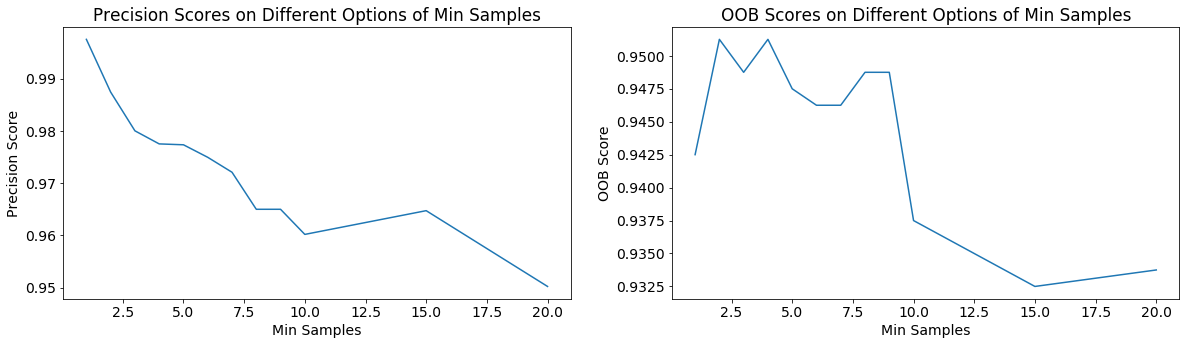

In [42]:
oob_scores = []
precision_scores = []
min_samples_leaf_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]

for min_samples in min_samples_leaf_options:
    model_rf = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42, min_samples_leaf=min_samples)
    model_rf.fit(X_train, y_train)
    print("Min Samples Leaf:", min_samples)
    y_train_pred = model_rf.predict(X_train)
    precision_train = precision_score(y_train, y_train_pred)
    oob_score = model_rf.oob_score_
    print('Precision score:', precision_train)
    print('OOB score:', oob_score)
    oob_scores.append(oob_score)
    precision_scores.append(precision_train)
    print("\n")

plt.rcParams["font.size"] = 14
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(min_samples_leaf_options, precision_scores)
plt.xlabel('Min Samples')
plt.ylabel('Precision Score')
plt.title('Precision Scores on Different Options of Min Samples')

plt.subplot(1, 2, 2)
plt.plot(min_samples_leaf_options, oob_scores)
plt.xlabel('Min Samples')
plt.ylabel('OOB Score')
plt.title('OOB Scores on Different Options of Min Samples')
plt.show()

#### Tuning Multiple Parameters

In [43]:
# run GridSearchCV to tune hyparameters for Random Forest Classifier
model = RandomForestClassifier(oob_score=True, random_state=random_state)
parameters = {"n_estimators":[20, 40, 60, 80, 100],
             "max_depth":[7, 8, 9, 10, 11, 12, 13, 14],
             "min_samples_leaf":[2, 3, 4, 5, 6, 7, 8, 9, 10, 15],
             "max_features":["auto", None, "log2"]}
score_func = 'precision'
search_parameters(model, parameters, num_folds, precisions)


Optimized Model:
---------
Evaluation score function: make_scorer(precision_score) = 0.9645302295918367
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=True, random_state=42, verbose=0, warm_start=False)


The best estimators we got from Random Forest Classifier are:
- n_estimators = 20
- max_depth = 8
- min_sample_leaf = 3
- max_features = "auto" (which is the squared root of number of features in train dataset)

This gave us the evaluation score as 96.453%.

### 3.2.3 Best Model

In [44]:
# Choose model with highest precision score
model = max(precisions, key=precisions.get)
print('\nPredictions calculated using model with highest precision score:')
print(model)

# Train model on entire train dataset
model.fit(X_train, y_train)


Predictions calculated using model with highest precision score:
LogisticRegression(C=1.2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


C:\Users\tduong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [45]:
# Get names of all independent variables in train set
features = X_train.columns

coefs = {}

# Print coefficents for all features
for coef, feature in zip(model.coef_[0], features):
    coefs[feature] = coef
    
print(coefs)

{'Daily Time Spent on Site': -4.7913962307030165, 'Age': 3.7936786144667844, 'Area Income': -2.918204877011236, 'Daily Internet Usage': -5.511031120910604, 'Male': -0.261441898939515, 'Country': 0.002816190838754283}


### 3.2.4 Confusion Matrix

In [46]:
# Predictions based on training dataset
y_train_pred = model.predict(X_train)

# Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

print("The confusion matrix:\n", conf_matrix)
print("Precision Score:", precision_score(y_train, y_train_pred))
print("Recall Score:", recall_score(y_train, y_train_pred))

The confusion matrix:
 [[396   5]
 [ 26 373]]
Precision Score: 0.9867724867724867
Recall Score: 0.9348370927318296


In [47]:
def summary_metrics(y, y_pred):
    conf_matrix = confusion_matrix(y, y_pred)
    TN = conf_matrix[0,0]
    FP = conf_matrix[0,1]
    FN = conf_matrix[1,0]
    TP = conf_matrix[1,1]
    
    # Print the confusion matrix
    print("Confusion Matrix:\n", conf_matrix)
    
    # Print accuracy, precision and recall scores
    print("Accuracy:", round(accuracy_score(y, y_pred), 2))
    print("Precision:", round(precision_score(y, y_pred), 2))
    print("Recall:", round(recall_score(y, y_pred), 2))
    
    print("\nConversion to Montary Values:\n")
    print("True Positive:", round((float(TP) * 100), 2), "CAD")
    print("False Positive:", round((float(FP) * -1050), 2), "CAD")
    print("False Negative:", round((float(FN) * 1100), 2), "CAD")
    print("True Negative:", round((float(TN) * 0), 2), "CAD")
    
    # Return on investment
    investment_return = (TP * 100) + (FP * -1050) + (FN * 1100) + (TN * 0)
    print("Profit:", round(float(investment_return),2), "$")    

In [48]:
# Metric summary with our best model on the training set
summary_metrics(y_train, y_train_pred)

Confusion Matrix:
 [[396   5]
 [ 26 373]]
Accuracy: 0.96
Precision: 0.99
Recall: 0.93

Conversion to Montary Values:

True Positive: 37300.0 CAD
False Positive: -5250.0 CAD
False Negative: 28600.0 CAD
True Negative: 0.0 CAD
Profit: 60650.0 $


Using our best model to predict the target based on the training set, there are 5 instances which were predicted as '1' (click on the ad) but in realistic, these potential customers did not click on the ad. It would cause the company in lossing 5,250CAD.

Let's look at the probability distribution of our model to see if increasing the threshold could be beneficial to reduce the number of false positive, consequently reducing our loss.

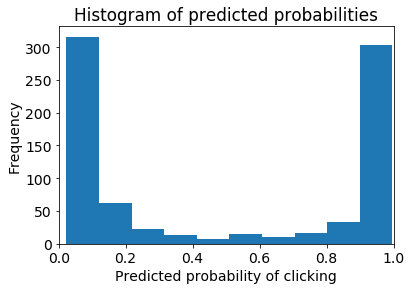

In [49]:
y_train_prob = model.predict_proba(X_train)[:,1]

plt.rcParams["font.size"] = 14
plt.hist(y_train_prob, bins=10)
plt.xlim(0, 1)
plt.title("Histogram of predicted probabilities")
plt.xlabel("Predicted probability of clicking")
plt.ylabel("Frequency")
plt.savefig("histogram-train1.png", bbox_inches='tight')

Based on the chart, it seems that our model does not carry a lot of ambiguity when it was predicting if someone would click on the ad. We could still increase our threshold to 0.65 to decrease the number of false positive cases, even though our current model seems quite categorical.

In [50]:
y_train_prob = model.predict_proba(X_train)[:,1]
y_train_pred_rev = np.where(y_train_prob < 0.65, 0, 1)
summary_metrics(y_train, y_train_pred_rev)

Confusion Matrix:
 [[400   1]
 [ 42 357]]
Accuracy: 0.95
Precision: 1.0
Recall: 0.89

Conversion to Montary Values:

True Positive: 35700.0 CAD
False Positive: -1050.0 CAD
False Negative: 46200.0 CAD
True Negative: 0.0 CAD
Profit: 80850.0 $


Let's use the model to predict the target variable on test set

In [51]:
y_test_pred = model.predict(X_test)
summary_metrics(y_test, y_test_pred)

Confusion Matrix:
 [[97  2]
 [ 6 95]]
Accuracy: 0.96
Precision: 0.98
Recall: 0.94

Conversion to Montary Values:

True Positive: 9500.0 CAD
False Positive: -2100.0 CAD
False Negative: 6600.0 CAD
True Negative: 0.0 CAD
Profit: 14000.0 $


In [52]:
y_test_prob = model.predict_proba(X_test)[:,1]
y_test_pred_rev = np.where(y_test_prob < 0.65, 0, 1)
summary_metrics(y_test, y_test_pred_rev)

Confusion Matrix:
 [[99  0]
 [ 7 94]]
Accuracy: 0.96
Precision: 1.0
Recall: 0.93

Conversion to Montary Values:

True Positive: 9400.0 CAD
False Positive: -0.0 CAD
False Negative: 7700.0 CAD
True Negative: 0.0 CAD
Profit: 17100.0 $


Our test set has a sample size of 200 customers. **With the new threshold, our predicted overall profit would be 17,100CAD**. This includes:
- Profit of 9,400CAD from true positives
- Profit of 7,700CAD from false negatives
- Loss of 0CAD from false positives

Indeed, the false negatives are extremely rewarding considering this particular problem. There could be losts from the false positives but the count will be less than 2. We can state that the results are excellent considering the margin of error and the predicted profit.

# 4. Actionable Recommendations

According to our model and analysis, we can identify the potential customers by getting information of:
- Daily Time Spent on Site
- Daily Internet Usage
- Area Income
- Age

By getting this information, we can target new customers with our ad campaign to maximize the chance of a return on investment.

From our exploratory data analysis, our targeted population would be customers with:
- Lower income
- Less time spent on the internet
- Less tiem spent on site
- Older than our average sample (mean around 35 years old)

Also by increasing our threshold from our model, we can minimize the number of wrong targets to minize loss which will optimize our business approach.
